# Algorithmic Fairness, Accountability, and Ethics, Spring 2024
# Exercise 4

## Task 0 (Setup)

We use the same dataset as in week 2 and 3. If you missed to install the module, please carry out the installation tasks at <https://github.com/zykls/folktables#basic-installation-instructions>.

After successful installation, you should be able to run the following code to generate a prediction task.
To make your life easier, we made the `BasicProblem`-magic from the `folktables` package (see exercises of week 2) explicit in this task.
This way, you can get access to different encodings of the data. 

In [1]:
# Importing libraries 
# TODO check that we use them all and delete the ones we don't

# the basic ones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data import
from folktables.acs import adult_filter
from folktables import ACSDataSource

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# performance
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import shap


In [2]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["SCHL"]>=15]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)


In [3]:

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [4]:
# sampling 100 datapoints 

X_test_sample = X_test[0:50]
y_test_sample = y_test[0:50]

# Task

1. Train a black-box model classifier (for example, use a random forest, a gradient-boosted decision tree, an SVM, or a Neural Network). Report on its accuracy. If you have used a tree data structure such as RF or gradient-boosted decision trees, report on the feature importance.


2. Use the `shap` module to explain predictions on your black-box model. Do the same with a white-box model that you have trained during last week's exercises. Contrast the two models to each other: What are similarities, how do they differ? As shown in the lecture, provide a summary plot, a dependence plot,  a  force plot for a negatively/positively predicted feature vector, and summary plot on the interaction values.


# logistic regression from slides
most cells run, some don't but idk why

In [5]:
# logistic regression
scaler = ColumnTransformer([("scaler", StandardScaler(), ["AGEP"])], remainder="passthrough")
logistic_model = Pipeline(steps=[("scaler",scaler),("logi", LogisticRegression(max_iter=5000, penalty="l2", C= 0.8497534359086438, tol=1e-4, solver = "saga"))])
logistic_model.fit(X_train, y_train)
X_train_2 = logistic_model["scaler"].transform(X_train)
X_test_2 = logistic_model["scaler"].transform(X_test)
log_y_pred= logistic_model.predict(X_test)
log_y_prob = logistic_model.predict_proba(X_test)[:, 1]

In [6]:
X_test_3 = logistic_model["scaler"].transform(X_test_sample)

# Initialize SHAP explainer
explainer_log = shap.Explainer(logistic_model["logi"], X_train_2, feature_names = np.array(X_train.columns))
shap_values_log = explainer_log(X_test_2)


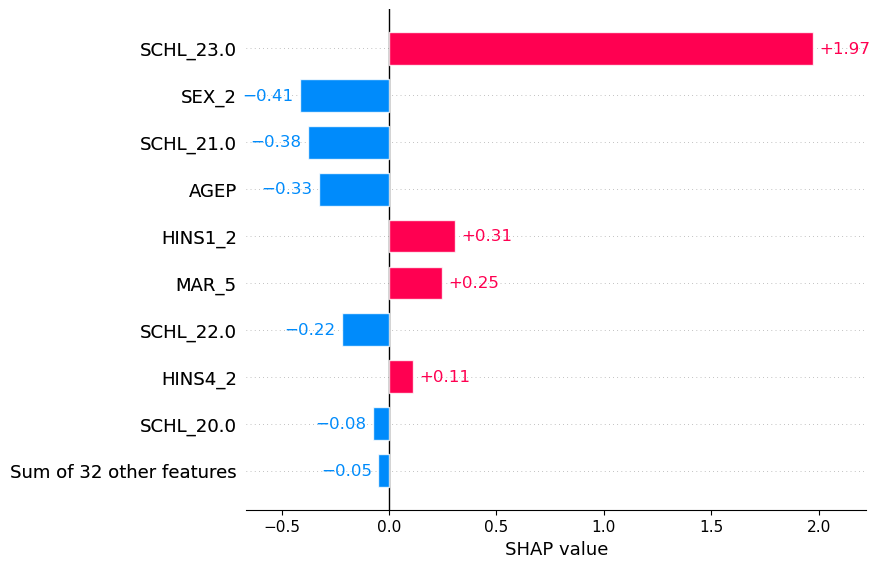

In [7]:
shap.plots.bar(shap_values_log[44])

we want to see the size of the impact generally

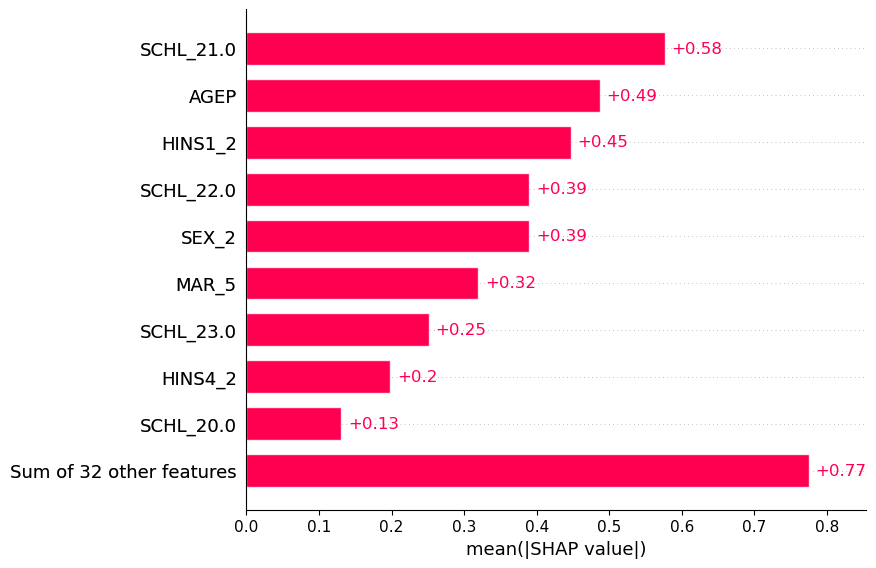

In [8]:
shap.plots.bar(shap_values_log)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


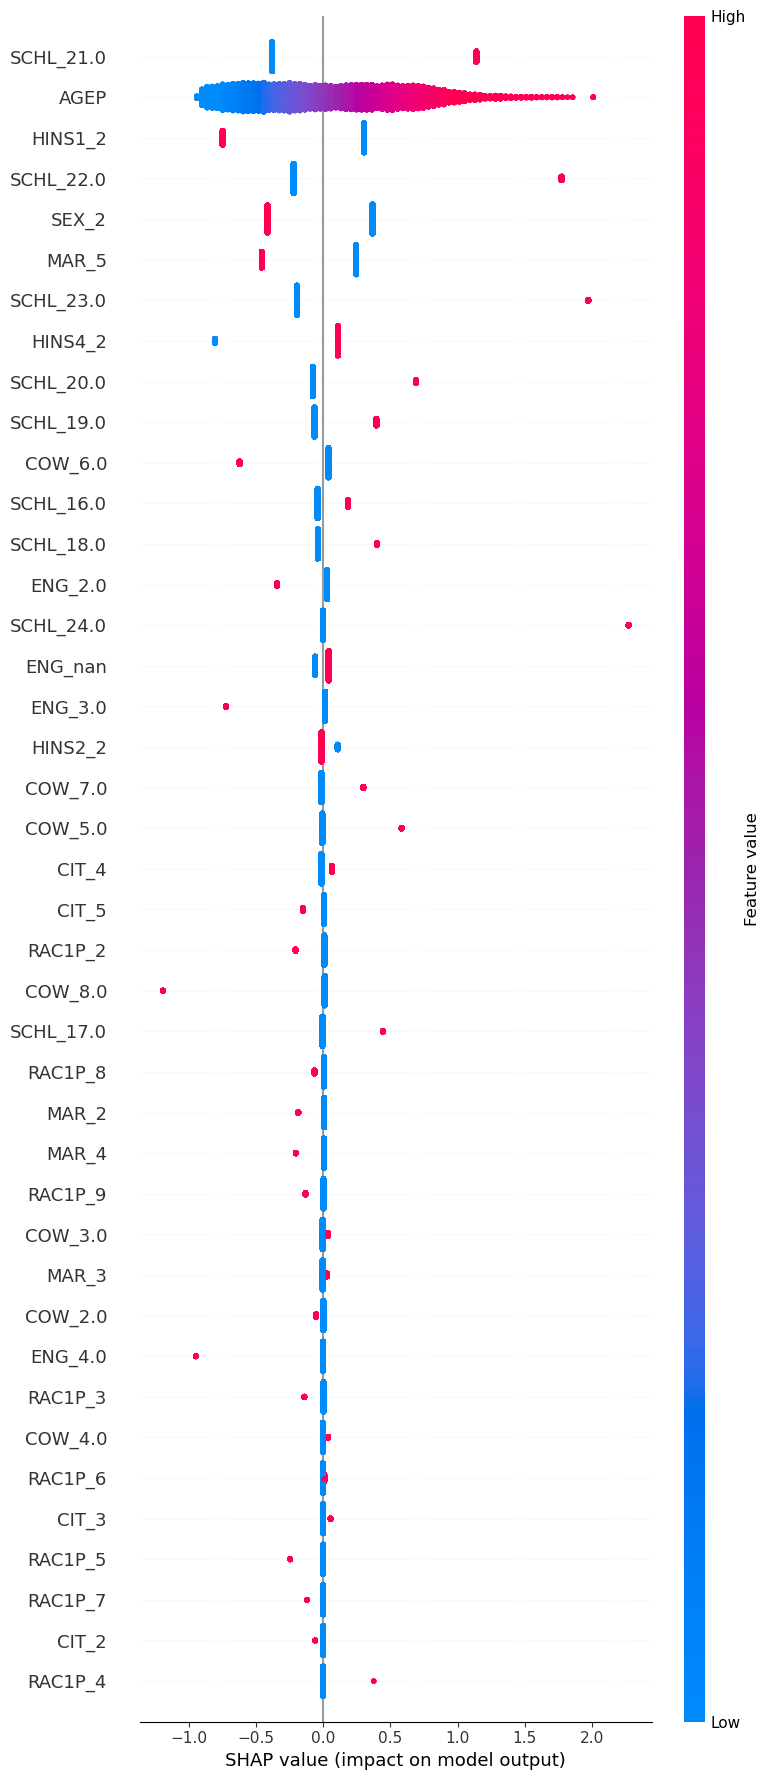

In [9]:

# 1. Summary plot
shap.summary_plot(shap_values_log, X_test_2, max_display=X_test_2.shape[1])


In [10]:
shap.initjs()

In [11]:
shap.force_plot(shap_values_log[44], link="logit")

# Random forest


In [14]:
# Random forest classifier

forest = RandomForestClassifier(max_depth = 5, random_state=23, n_jobs=-1, n_estimators=20)
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test_sample)
forest_y_prob = forest.predict_proba(X_test_sample)[:, 1]

In [15]:

forest_accuracy = accuracy_score(y_test_sample, forest_y_pred)
forest_accuracy

0.74

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

In [16]:
explainer_tree = shap.TreeExplainer(forest, X_train, feature_names = np.array(X_train.columns))


In [32]:

shap_values_tree = explainer_tree.shap_values(X_test)

100%|===================| 71106/71314 [00:29<00:00]        

In [33]:
print("Type of shap_vals:", type(shap_values_tree))
print("Shape of shap_vals.values:", shap_values_tree.values.shape if hasattr(shap_values_tree, "values") else "No values attribute")
print("Shape of shap_vals.base_values:", shap_values_tree.base_values.shape if hasattr(shap_values_tree, "base_values") else "No base_values attribute")


Type of shap_vals: <class 'list'>
Shape of shap_vals.values: No values attribute
Shape of shap_vals.base_values: No base_values attribute


In [36]:
if isinstance(shap_values_tree, list):
    shap_values_tree = shap_values_tree[1]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


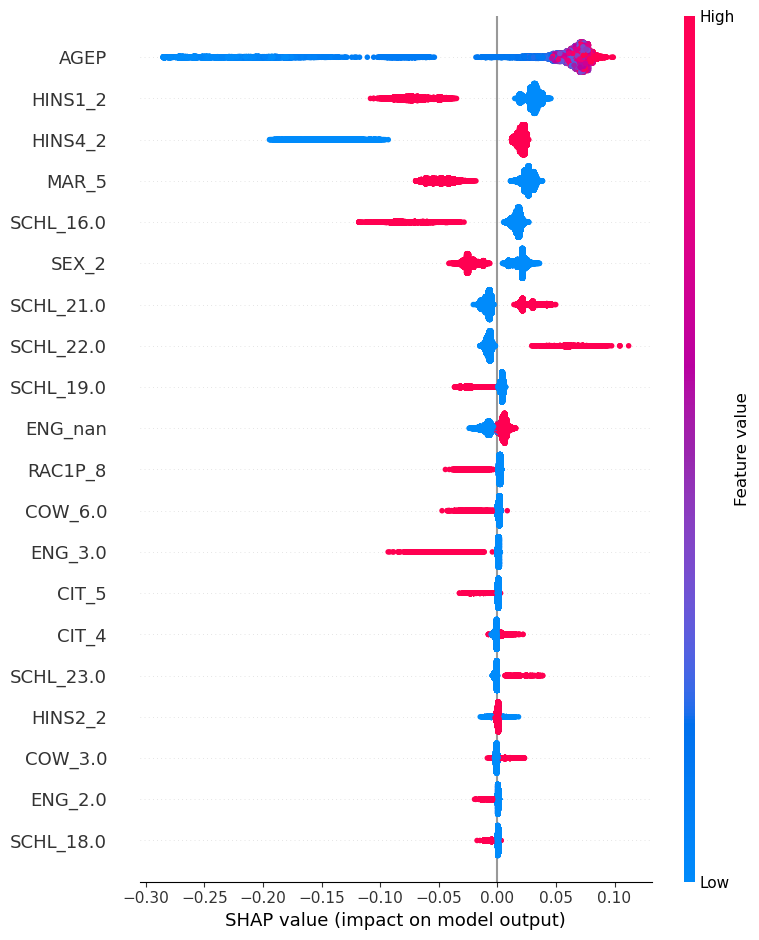

In [38]:
shap.summary_plot(shap_values_tree, X_test, feature_names=X_test.columns)


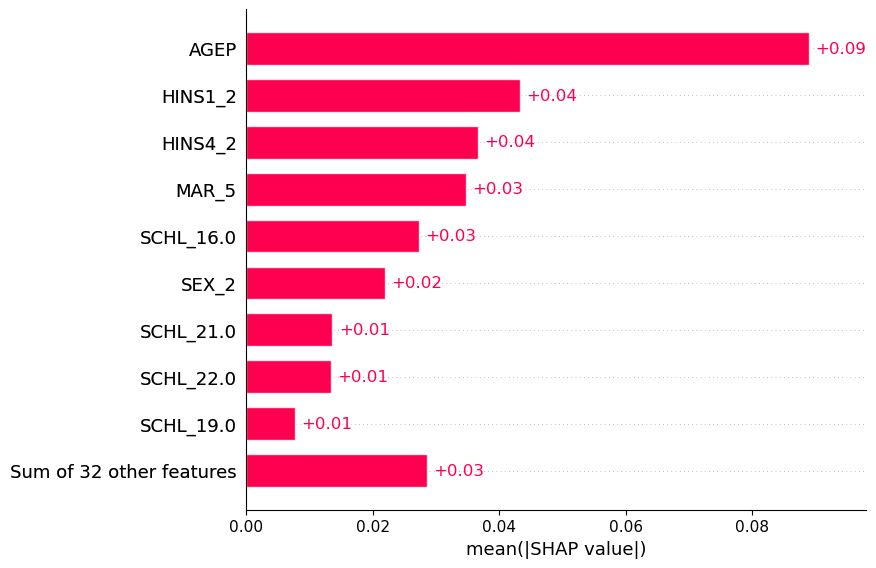

In [41]:
shap_exp = shap.Explanation(values=shap_values_tree,  
                            base_values=explainer_tree.expected_value[1] if isinstance(explainer_tree.expected_value, list) else explainer_tree.expected_value,
                            data=X_test,  
                            feature_names=X_test.columns)
shap.plots.bar(shap_exp)

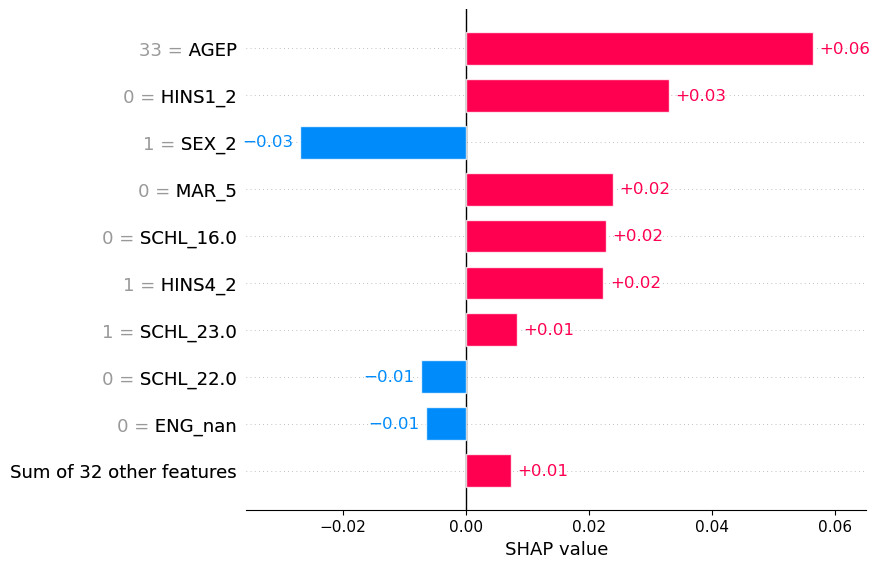

In [25]:

# Check if shap_vals is a list (for multi-class cases)
 # Select positive class SHAP values
# Convert to SHAP Explanation object
shap_exp = shap.Explanation(values=shap_values_tree.values[44][:,1],  # SHAP values for instance 44
                            base_values=shap_values_tree.base_values[44,1],  # Base value for class
                            data=X_test.iloc[44],  # Original feature values
                            feature_names=X_test.columns)  # Feature names

# Plot bar chart
shap.plots.bar(shap_exp)

In [44]:

#shap_exp = shap.Explanation(shap_vals[0])
# Select the instance (44th sample)
shap_exp = shap.Explanation(values=shap_vals.values[44],  # SHAP values for instance 44
                            base_values=shap_vals.base_values[44],  # Corresponding base value
                            data=X_test.iloc[44],  # Feature values for instance 44
                            feature_names=X_test.columns)  # Feature names



each bar represents a feature of the dataset. the length shows the mean absolute shap value, the longer, the more impact the feature has on model prediction. 

remember that positive shap vals mean that the feature increases the prediction, and negative mean that they decrease the prediction. 

summary plot helps see which features are most important globally. 

3. Reflect on the explanations: How does the white box models's (from last week) black-box explanation relate to its white-box explanation? Which classifier would you prefer when deploying a model as part of the machine learning pipeline? 